In [1]:
import cv2
import numpy as np
import tensorflow as tf

# 1. Image Acquisition

In [2]:
# Initialize the camera (0 is the default camera, change the index if you have multiple cameras)
camera = cv2.VideoCapture(0)

# Check if the camera is opened successfully
if not camera.isOpened():
    print("Error: Could not open the camera.")
else:
    print("Camera opened successfully!")

# Capture an image from the camera
ret, frame = camera.read()

Camera opened successfully!


# 2. Image Preprocessing

In [3]:
# Capture an image from the camera
ret, frame = camera.read()

# Check if the image was captured successfully
if ret:
    # ----------------------------------------------------------------------
    # Step 1: Normalization
    # Normalize the brightness and contrast of the image
    normalized_image = cv2.normalize(
        frame, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX
    )

    # ----------------------------------------------------------------------
    # Step 2: Filtering
    # Convert to grayscale to simplify filtering operations
    gray_image = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian Blur to reduce noise
    filtered_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # ----------------------------------------------------------------------
    # Step 3: Segmentation using Thresholding
    # Use adaptive thresholding to segment the product from the background
    segmented_image = cv2.adaptiveThreshold(
        filtered_image,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        11,
        2,
    )

    # save images
    cv2.imwrite("captured_image.jpg", frame)
    cv2.imwrite("normalized_image.jpg", normalized_image)
    cv2.imwrite("filtered_image.jpg", filtered_image)
    cv2.imwrite("segmented_image.jpg", segmented_image)

    # Display the results of each preprocessing step
    cv2.imshow("Original Image", frame)
    cv2.imshow("Normalized Image", normalized_image)
    cv2.imshow("Filtered Image", filtered_image)
    cv2.imshow("Segmented Image", segmented_image)

    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Error: Could not capture an image.")

# Release the camera resources
camera.release()

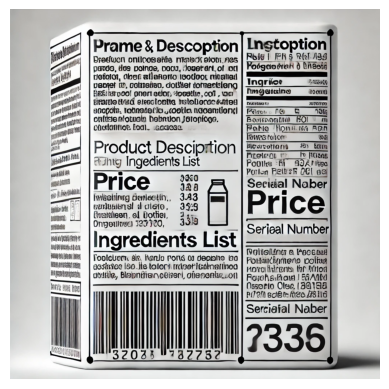

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# Load the image
image_path = "captured_image.jpg"
# image_path = "image2.webp"
image = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()


# 3. Extract Text from the Image

In [5]:
import pytesseract
import cv2

# Convert the image to OpenCV format
image_cv = np.array(image)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)

# Convert the image to grayscale for better OCR results
gray_image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding to enhance text visibility
thresh_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)

# Use Tesseract OCR to extract text from the image
extracted_text = pytesseract.image_to_string(thresh_image)
print("Extracted Text from the Image:")
print(extracted_text)


Extracted Text from the Image:
Perraract
sennaleat
rang
ai
est

Lngtoption||
Rold [PR 9-208

Prame z , Descoption
Breduon onlloesatie miqedt atonrAes
fazda, des votnde, no0s, dogatart_ot.ion | Forgan! heal
Hatalat, diaeG ailanatio:isodeor nivatial

to, cetneien. dobiist iomactlang | Inariice en
i Ragataina dou
———_—_

Batt atpeo! Sheri selon “ocathe, cof . aa
raitte tvd etesctonita Ire tohecceétied
aaogdls, rotnatecio jcoptia ncosmUontl
ofittcenfotials hebruon Jeroploge.
‘chetamlion foal. ianaesa. -
peat :

Product Descipztion
fini Ingedients List
Price 33 A

fntebinng Geleatin,, 3383 Fl

Dresnents acme | |
ames fo G Adis
Boormoahns BOL sm
ORS Colon Bal |
Kleaottara $2) bein
Ferelerap_fn ay fates
Pooike Fn

Pottaq Belle F ae iG
Secicial Naber.

Price)

Serial Number

vurluwinal dh olafo, 9479
fraiciean. el Dodie, J ss
Ongoultae) 729320, ERIE

Ingredients List

Tooleber als, Rando ron 01 depishe tsa
acdisies 160.lie toieri trdcet'IGainaithnoa
cove, BlsbnBienesverl olieeartey.2o(1 Blstnd

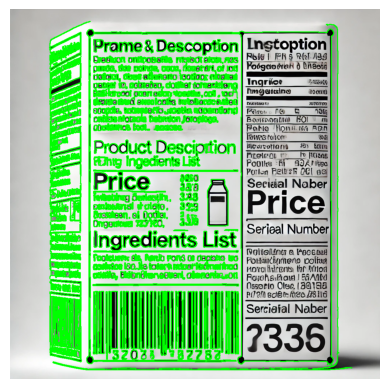

In [6]:
# Detect edges using the Canny edge detector
edges = cv2.Canny(gray_image, 50, 150)

# Find contours based on the detected edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the detected contours on the original image
contour_image = image_cv.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Display the image with detected contours
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide the axes
plt.show()


# 4. Deep Learning & Machine Learning

In [7]:
import tensorflow as tf

# Preprocess the image for MobileNetV2
image_resized = image.resize((224, 224))  # Resize to the input size of the model
image_array = np.array(image_resized) / 255.0  # Normalize pixel values
input_image = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Load the pre-trained MobileNetV2 model
model = tf.keras.applications.MobileNetV2(weights='imagenet')

# Perform object detection
predictions = model.predict(input_image)

# Decode the predictions to get the top 3 predictions
decoded_predictions = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=3)[0]
print("Top Predictions for the Image:")
for i, (imagenet_id, label, confidence) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({confidence * 100:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Top Predictions for the Image:
1: packet (13.84%)
2: hard_disc (11.69%)
3: book_jacket (9.99%)


In [8]:
product_database = {
    'Packet': {'name': 'packet', 'price': '$2.99', 'specifications': 'Bar soap for cleaning', 'serial': '12345'},
    'Shampoo': {'name': 'Shampoo', 'price': '$5.49', 'specifications': 'Haircare product in a bottle', 'serial': '67890'},
    'Toothpaste': {'name': 'Toothpaste', 'price': '$3.25', 'specifications': 'Fluoride toothpaste in a tube', 'serial': '24680'}
}

# Example: Fine-tune the pre-trained model for your product data (optional)
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the layers of the base model

# Add a custom classification layer on top of the base model
custom_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(product_database), activation='softmax')
])

# Compile the custom model
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Check if the identified product is correct or if it needs to be rejected
def real_time_feedback(product_name, product_details):
    if product_name == "Unknown Product" or not product_details:
        print("Defective or incorrect product detected")
        # Code to trigger an alert or automated response (e.g., reject product)
    else:
        print("Product is correctly identified and accepted.")


In [10]:
# Function to display product details after identification
def display_product_details(product_name, product_details):
    if product_details:
        print(f"Product Identified: {product_name}")
        print(f"Price: {product_details['price']}")
        print(f"Specifications: {product_details['specifications']}")
    else:
        print("Product not found in the database.")


In [11]:
# Function to match the product label from the CNN model to the product database
def match_product_with_database(predicted_label):
    for product_name, details in product_database.items():
        print(product_name, details)
        if details['name'] == predicted_label:
            return product_name, details
    return "Unknown Product", {}

In [12]:
# Example usage of all the functions
predicted_label = decoded_predictions[0][1]  # Extract the label of the top prediction
print(predicted_label)
product_match, product_details = match_product_with_database(predicted_label)
display_product_details(product_match, product_details)
real_time_feedback(product_match, product_details)


packet
Packet {'name': 'packet', 'price': '$2.99', 'specifications': 'Bar soap for cleaning', 'serial': '12345'}
Product Identified: Packet
Price: $2.99
Specifications: Bar soap for cleaning
Product is correctly identified and accepted.
